In [1]:
import os 
import sys
import random
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import lognorm
from scipy.stats import norm 
from scipy import integrate
from scipy.stats import gmean

from scipy.stats import pearsonr

import statsmodels.api as sm 
import statsmodels.formula.api as smf

### src; https://github.com/arkottke/pyrotd
import pyrotd
pd.set_option('display.max_rows', 100)
from scipy import stats
from efficiency_OLS import OLS
from Linear_model_fits import fit_against_IM_and_M, fit_against_IM_and_M_Rjb, fit_against_IM_and_Rjb

%load_ext autoreload
%autoreload 2

/Users/laxmandahal/opt/miniconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
with open('BuildingNames.txt', 'r') as f:
    BuildingList = f.read() 
BuildingList = BuildingList.split('\n')
BuildingList

['s1_48x32_high',
 's1_48x32_veryhigh',
 's1_96x48_high',
 's1_96x48_veryhigh',
 's2_48x32_high',
 's2_48x32_veryhigh',
 's2_96x48_high',
 's2_96x48_veryhigh',
 's4_96x48_high',
 's4_96x48_veryhigh']

In [3]:
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'

## time period of the buildings
T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])

numGM = 826
g = 980.665 ## converts GM record to cm/sec^2

def compute_RotDxx_EDP(edpX, edpZ, percentile = 50):
    angles = np.arange(0, 180, step=1)
    radians = np.radians(angles)
    coeffs = np.c_[np.cos(radians), np.sin(radians)]
    
    edp_stacked = np.vstack([edpX, edpZ])
    rotated_edp = np.dot(coeffs, edp_stacked)
    percentile_edp = np.percentile(rotated_edp, q = percentile, axis = 0, interpolation='linear')
    return percentile_edp

def compute_KL_divergence(p, q):
    mu1 = np.mean(p)
    mu2 = np.mean(q)
    std1 = np.std(p, ddof=0)
    std2 = np.std(q, ddof=0)
    
    kl = np.log(std2 / std1) + (std1 ** 2 + (mu1 - mu2)**2) / (2 * std2 ** 2) - 0.5
    return kl
    

In [4]:
# heresi_GM_dir = os.path.join(baseDir, *['References', 'Heresi GMs'])
# os.chdir(heresi_GM_dir)
# heresiGM = pd.read_csv('Ground Motion Records.csv')
# RSNs = heresiGM['Record Sequence Number\n(NGA-West2)'].values
# np.savetxt('Heresi_831_RSNs.txt',[RSNs], delimiter=',', fmt='%d')

In [5]:
gminfo_h1 = pd.read_csv(r'data/Complete_GM_info_h1.csv')
gminfo_h1 = gminfo_h1.set_index('key_0')
gminfo_h1.index.names = ['GMID']

In [6]:
gminfo_h2 = pd.read_csv(r'data/Complete_GM_info_h2.csv')
gminfo_h2 = gminfo_h2.set_index('key_0')
gminfo_h2.index.names = ['GMID']

In [7]:
gminfo_rotD50 = pd.read_csv(r'data/Complete_GM_info_RotD50.csv')
gminfo_rotD50 = gminfo_rotD50.set_index('key_0')
gminfo_rotD50.index.names = ['GMID']
gminfo_rotD50.columns

Index(['PGA', 'PGV', 'DS_5to75', 'DS_5to95', 'CAV', 'T_0.01', 'T_0.02',
       'T_0.03', 'T_0.04', 'T_0.05',
       ...
       'SI', 'ASI', 'DSI', 'Sa_avg', '5-75% Duration (sec)_NGA2',
       '5-95% Duration (sec)_NGA2', 'Magnitude', 'Distance_Rjb',
       'Distance_rup', 'Vs_30'],
      dtype='object', length=156)

In [8]:
# sv_rotD50 = pd.read_csv('data/Spectral_velocity_rotD50.csv', index_col='GMID')
# sd_rotD50 = pd.read_csv('data/Spectral_Displacement_rotD50.csv', index_col='GMID')

In [9]:
def extract_EDP_data(baseDir, buildingIndex, edp_type = 'SDR', pairingID = 1, numGM = 826, 
                    remove_collapse = False):
    
    dataDir = dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])
#     dataDir = dataDir = os.path.join(baseDir, *['Results', 'IM_study', BuildingList[buildingIndex]])
    edp = pd.read_csv(os.path.join(dataDir, '%s.csv'%edp_type), header = None)
    
    numStory = int(BuildingList[buildingIndex].split('_')[0][1])
    base_col_names = ['Hazard_Level', 'Pairing_ID', 'GM_ID']
    if edp_type == 'PFA':
        story_col_name = ['Story_%i'%x for x in range(numStory + 1)]
    else:
        story_col_name = ['Story_%i'%x for x in range(1, numStory + 1)]
    col_names = base_col_names + story_col_name
    edp = edp.rename(columns = dict(zip(edp.columns, col_names)))
    
    if pairingID == 1:
        edp = edp[edp['Pairing_ID'] == pairingID]
        start_index_multiplier = 0
        end_index_multiplier = 1
    elif pairingID == 2:
        edp = edp[edp['Pairing_ID'] == pairingID]
        start_index_multiplier = 2
        end_index_multiplier = 3
    else:
        pass
        
    direction = []
    for i in range(len(edp)):
        if ((edp['GM_ID'].values[i]> numGM * start_index_multiplier) &
            (edp['GM_ID'].values[i]<= numGM * end_index_multiplier)):
            direction.append('X')
        elif ((edp['GM_ID'].values[i] > 826 * end_index_multiplier) &
              (edp['GM_ID'].values[i] <= 826 * (end_index_multiplier + 1))):
            direction.append('Z')
        else:
            pass

    edp['Direction'] = direction
    if edp_type == 'SDR':
        if remove_collapse:
            edp = edp[edp['Story_1'] < 0.1]
    edp['Max_EDP'] = edp.loc[:,story_col_name].max(axis=1)
#     print(len(direction))
    return edp

In [ ]:
sdr = extract_EDP_data(baseDir, 9, edp_type='SDR', pairingID=1, numGM=826, remove_collapse=True)
sdr_all = extract_EDP_data(baseDir, 9, edp_type='SDR', pairingID=1, numGM=826, remove_collapse=False)
sdr.head()

In [ ]:
gm_ID_index_X = [sdr_all['GM_ID'].tolist().index(x) for x in sdr[sdr['Direction'] == 'X']['GM_ID'].values]
len(gm_ID_index_X)

In [ ]:
ols_sdrX.qqplot()

In [25]:
def compile_KL_divergence(building_Index, baseDir, IM_List, df_IMs, pairingID = 1,
                          numGM = 826, remove_collapse = False, KL_on_residual=False,
                         use_predicted_IM):
    ## time period of the buildings, used to get Sa(T1)
    T = np.array([0.13, 0.12, 0.22, 0.22, 0.16, 0.15, 0.26, 0.25, 0.49, 0.49])
    
    sdr_all = extract_EDP_data(baseDir, building_Index, edp_type='SDR', pairingID=pairingID,
                           numGM=numGM, remove_collapse=False)
    sdr = extract_EDP_data(baseDir, building_Index, edp_type='SDR', pairingID=pairingID,
                           numGM=numGM, remove_collapse=remove_collapse)
    
    sdrX = sdr[sdr['Direction'] == 'X']['Max_EDP'].values
    sdrZ = sdr[sdr['Direction'] == 'Z']['Max_EDP'].values
    pfa = extract_EDP_data(baseDir, building_Index, edp_type='PFA', pairingID=pairingID, numGM=numGM)
    pfa = pfa[pfa['GM_ID'].isin(sdr['GM_ID'].values)] # if collapse is remove, this gives consistent pfa data 
    pfaX = pfa[pfa['Direction'] == 'X']['Max_EDP'].values
    pfaZ = pfa[pfa['Direction'] == 'Z']['Max_EDP'].values
    
    gm_ID_index_X = [sdr_all[sdr_all['Direction']=='X']['GM_ID'].tolist().index(x) for x in sdr[sdr['Direction'] == 'X']['GM_ID'].values]
    gm_ID_index_Z = [sdr_all[sdr_all['Direction']=='Z']['GM_ID'].tolist().index(x) for x in sdr[sdr['Direction'] == 'Z']['GM_ID'].values]
    
    M = df_IMs['Magnitude'].values
    Rjb = df_IMs['Distance_Rjb'].values
    

    kld_sdrX = []
    kld_sdrZ = []
    kld_pfaX = []
    kld_pfaZ = []
    
    kld_sdrX_R = []
    kld_sdrZ_R = []
    kld_pfaX_R = []
    kld_pfaZ_R = []
    
    kld_sdrX_M_R = []
    kld_sdrZ_M_R = []
    kld_pfaX_M_R = []
    kld_pfaZ_M_R = []
    
    for i in range(len(IM_List)):

        if IM_List[i] == 'SaT1':
            IM = df_IMs['T_%s'%T[building_Index]].values
        else:
            IM = df_IMs[IM_List[i]]
        
#         print(len(IM[gm_ID_index_Z]), len(sdrZ))
#         print(len(IM[gm_ID_index_X]), len(sdrX))
        sdrX_pred = OLS(sdrX, IM[gm_ID_index_X]).get_pred_values()
        sdrZ_pred = OLS(sdrZ, IM[gm_ID_index_Z]).get_pred_values()
        pfaX_pred = OLS(pfaX, IM[gm_ID_index_X]).get_pred_values()
        pfaZ_pred = OLS(pfaZ, IM[gm_ID_index_Z]).get_pred_values()

        sdrX_pred_M = fit_against_IM_and_M(sdrX, IM[gm_ID_index_X],
                                           M[gm_ID_index_X]).get_prediction().predicted_mean
        sdrZ_pred_M = fit_against_IM_and_M(sdrZ, IM[gm_ID_index_Z],
                                           M[gm_ID_index_Z]).get_prediction().predicted_mean
        pfaX_pred_M = fit_against_IM_and_M(pfaX, IM[gm_ID_index_X],
                                           M[gm_ID_index_X]).get_prediction().predicted_mean
        pfaZ_pred_M = fit_against_IM_and_M(pfaZ, IM[gm_ID_index_Z],
                                           M[gm_ID_index_Z]).get_prediction().predicted_mean
        
        sdrX_pred_R = fit_against_IM_and_Rjb(sdrX, IM[gm_ID_index_X],
                                             Rjb[gm_ID_index_X]).get_prediction().predicted_mean
        sdrZ_pred_R = fit_against_IM_and_Rjb(sdrZ, IM[gm_ID_index_Z],
                                             Rjb[gm_ID_index_Z]).get_prediction().predicted_mean
        pfaX_pred_R = fit_against_IM_and_Rjb(pfaX, IM[gm_ID_index_X],
                                             Rjb[gm_ID_index_X]).get_prediction().predicted_mean
        pfaZ_pred_R = fit_against_IM_and_Rjb(pfaZ, IM[gm_ID_index_Z],
                                             Rjb[gm_ID_index_Z]).get_prediction().predicted_mean
        
        sdrX_pred_M_R = fit_against_IM_and_M_Rjb(sdrX, IM[gm_ID_index_X], M[gm_ID_index_X],
                                             Rjb[gm_ID_index_X]).get_prediction().predicted_mean
        sdrZ_pred_M_R = fit_against_IM_and_M_Rjb(sdrZ, IM[gm_ID_index_Z], M[gm_ID_index_Z],
                                             Rjb[gm_ID_index_Z]).get_prediction().predicted_mean
        pfaX_pred_M_R = fit_against_IM_and_M_Rjb(pfaX, IM[gm_ID_index_X], M[gm_ID_index_X],
                                             Rjb[gm_ID_index_X]).get_prediction().predicted_mean
        pfaZ_pred_M_R = fit_against_IM_and_M_Rjb(pfaZ, IM[gm_ID_index_Z], M[gm_ID_index_Z],
                                             Rjb[gm_ID_index_Z]).get_prediction().predicted_mean

        
        if KL_on_residual:
            sdrX_pred = OLS(sdrX, IM[gm_ID_index_X]).get_residual()
            sdrZ_pred = OLS(sdrZ, IM[gm_ID_index_Z]).get_residual()
            pfaX_pred = OLS(pfaX, IM[gm_ID_index_X]).get_residual()
            pfaZ_pred = OLS(pfaZ, IM[gm_ID_index_Z]).get_residual()

            sdrX_pred_M = fit_against_IM_and_M(sdrX, IM[gm_ID_index_X], M[gm_ID_index_X]).resid
            sdrZ_pred_M = fit_against_IM_and_M(sdrZ, IM[gm_ID_index_Z], M[gm_ID_index_Z]).resid
            pfaX_pred_M = fit_against_IM_and_M(pfaX, IM[gm_ID_index_X], M[gm_ID_index_X]).resid
            pfaZ_pred_M = fit_against_IM_and_M(pfaZ, IM[gm_ID_index_Z], M[gm_ID_index_Z]).resid

            sdrX_pred_R = fit_against_IM_and_Rjb(sdrX, IM[gm_ID_index_X], Rjb[gm_ID_index_X]).resid
            sdrZ_pred_R = fit_against_IM_and_Rjb(sdrZ, IM[gm_ID_index_Z], Rjb[gm_ID_index_Z]).resid
            pfaX_pred_R = fit_against_IM_and_Rjb(pfaX, IM[gm_ID_index_X], Rjb[gm_ID_index_X]).resid
            pfaZ_pred_R = fit_against_IM_and_Rjb(pfaZ, IM[gm_ID_index_Z], Rjb[gm_ID_index_Z]).resid
            
            sdrX_pred_M_R = fit_against_IM_and_M_Rjb(sdrX, IM[gm_ID_index_X], M[gm_ID_index_X],
                                             Rjb[gm_ID_index_X]).resid
            sdrZ_pred_M_R = fit_against_IM_and_M_Rjb(sdrZ, IM[gm_ID_index_Z], M[gm_ID_index_Z],
                                                 Rjb[gm_ID_index_Z]).resid
            pfaX_pred_M_R = fit_against_IM_and_M_Rjb(pfaX, IM[gm_ID_index_X], M[gm_ID_index_X],
                                                 Rjb[gm_ID_index_X]).resid
            pfaZ_pred_M_R = fit_against_IM_and_M_Rjb(pfaZ, IM[gm_ID_index_Z], M[gm_ID_index_Z],
                                                 Rjb[gm_ID_index_Z]).resid
            
            ## scipy.stats.entropy normalizes pk and qk if they don't sum to 1
#         kld_sdrX.append(stats.entropy(pk=sdrX_pred, qk=sdrX_pred_M))
#         kld_sdrZ.append(stats.entropy(pk=sdrZ_pred, qk=sdrZ_pred_M))
#         kld_pfaX.append(stats.entropy(pk=pfaX_pred, qk=pfaX_pred_M))
#         kld_pfaZ.append(stats.entropy(pk=pfaZ_pred, qk=pfaZ_pred_M))
        
#         kld_sdrX_R.append(stats.entropy(pk=sdrX_pred, qk=sdrX_pred_R))
#         kld_sdrZ_R.append(stats.entropy(pk=sdrZ_pred, qk=sdrZ_pred_R))
#         kld_pfaX_R.append(stats.entropy(pk=pfaX_pred, qk=pfaX_pred_R))
#         kld_pfaZ_R.append(stats.entropy(pk=pfaZ_pred, qk=pfaZ_pred_R))
        
        kld_sdrX.append(compute_KL_divergence(p=sdrX_pred, q=sdrX_pred_M))
        kld_sdrZ.append(compute_KL_divergence(p=sdrZ_pred, q=sdrZ_pred_M))
        kld_pfaX.append(compute_KL_divergence(p=pfaX_pred, q=pfaX_pred_M))
        kld_pfaZ.append(compute_KL_divergence(p=pfaZ_pred, q=pfaZ_pred_M))
        
        kld_sdrX_R.append(compute_KL_divergence(p=sdrX_pred, q=sdrX_pred_R))
        kld_sdrZ_R.append(compute_KL_divergence(p=sdrZ_pred, q=sdrZ_pred_R))
        kld_pfaX_R.append(compute_KL_divergence(p=pfaX_pred, q=pfaX_pred_R))
        kld_pfaZ_R.append(compute_KL_divergence(p=pfaZ_pred, q=pfaZ_pred_R))
        
        kld_sdrX_M_R.append(compute_KL_divergence(p=sdrX_pred, q=sdrX_pred_M_R))
        kld_sdrZ_M_R.append(compute_KL_divergence(p=sdrZ_pred, q=sdrZ_pred_M_R))
        kld_pfaX_M_R.append(compute_KL_divergence(p=pfaX_pred, q=pfaX_pred_M_R))
        kld_pfaZ_M_R.append(compute_KL_divergence(p=pfaZ_pred, q=pfaZ_pred_M_R))

    d = {
        'IM': IM_List,
        'KL(sdrX|im, sdrX|im,M)': kld_sdrX,
        'KL(sdrZ|im, sdrZ|im,M)': kld_sdrZ,
        'KL(pfaX|im, pfaX|im,M)': kld_pfaX,
        'KL(pfaZ|im, pfaZ|im,M)': kld_pfaZ,
        'KL(sdrX|im, sdrX|im,R)': kld_sdrX_R,
        'KL(sdrZ|im, sdrZ|im,R)': kld_sdrZ_R,
        'KL(pfaX|im, pfaX|im,R)': kld_pfaX_R,
        'KL(pfaZ|im, pfaZ|im,R)': kld_pfaZ_R,
        'KL(sdrX|im, sdrX|im,M,R)': kld_sdrX_M_R,
        'KL(sdrZ|im, sdrZ|im,M,R)': kld_sdrZ_M_R,
        'KL(pfaX|im, pfaX|im,M,R)': kld_pfaX_M_R,
        'KL(pfaZ|im, pfaZ|im,M,R)': kld_pfaZ_M_R
    }
    df = pd.DataFrame(d)
    return df


In [28]:
IM_list = ['SaT1', 'PGA', 'PGV', 'Sa_avg', 'CAV', 'SI', 'ASI', 'DSI','DS_5to75', 'DS_5to95' ]
a = compile_KL_divergence(9, baseDir, IM_list, gminfo_rotD50, pairingID=1, numGM=826, remove_collapse=False)
a.T

,0,1,2,3,4,5,6,7,8,9
IM,SaT1,PGA,PGV,Sa_avg,CAV,SI,ASI,DSI,DS_5to75,DS_5to95
"KL(sdrX|im, sdrX|im,M)",0.000045,0.000291,0.000001,0.000037,0.000088,0.0,0.000449,0.0,0.053417,0.038472
"KL(sdrZ|im, sdrZ|im,M)",0.000034,0.000228,0.000003,0.000027,0.000128,0.0,0.000378,0.0,0.047095,0.034712
"KL(pfaX|im, pfaX|im,M)",0.000002,0.0,0.000598,0.000003,0.002706,0.00022,0.0,0.000587,0.008053,0.004765
"KL(pfaZ|im, pfaZ|im,M)",0.000009,0.0,0.000975,0.000012,0.003798,0.000394,0.0,0.00107,0.005707,0.00301
"KL(sdrX|im, sdrX|im,R)",0.0005,0.000802,0.002175,0.000241,0.008595,0.000943,0.001002,0.031942,0.160528,0.154471
"KL(sdrZ|im, sdrZ|im,R)",0.000114,0.00014,0.000771,0.000035,0.004407,0.00041,0.000269,0.025583,0.111916,0.116212
"KL(pfaX|im, pfaX|im,R)",0.0,0.0,0.0009,0.0,0.003446,0.000399,0.0,0.039211,0.024003,0.041656
"KL(pfaZ|im, pfaZ|im,R)",0.000003,0.0,0.001665,0.0,0.004572,0.001101,0.0,0.057704,0.021466,0.034927
"KL(sdrX|im, sdrX|im,M,R)",0.001487,0.003285,0.002776,0.000911,0.009089,0.001335,0.004083,0.040275,0.219293,0.208145


In [29]:
a = compile_KL_divergence(9, baseDir, IM_list, gminfo_rotD50, pairingID=1, numGM=826, KL_on_residual=True)
a.T

,0,1,2,3,4,5,6,7,8,9
IM,SaT1,PGA,PGV,Sa_avg,CAV,SI,ASI,DSI,DS_5to75,DS_5to95
"KL(sdrX|im, sdrX|im,M)",0.00024,0.000896,0.000003,0.000201,0.000154,0.0,0.001454,0.0,0.008935,0.005766
"KL(sdrZ|im, sdrZ|im,M)",0.000352,0.001379,0.00001,0.000289,0.000406,0.0,0.002155,0.0,0.012157,0.007187
"KL(pfaX|im, pfaX|im,M)",0.000245,0.0,0.002047,0.000449,0.012305,0.001007,0.000035,0.000193,0.006698,0.001838
"KL(pfaZ|im, pfaZ|im,M)",0.000748,0.000011,0.003116,0.001827,0.018499,0.001391,0.0,0.000277,0.00605,0.001561
"KL(sdrX|im, sdrX|im,R)",0.003053,0.002695,0.00702,0.001423,0.027518,0.004377,0.003527,0.039147,0.07336,0.071446
"KL(sdrZ|im, sdrZ|im,R)",0.001262,0.00082,0.003867,0.000372,0.022447,0.002562,0.001488,0.033581,0.058403,0.058421
"KL(pfaX|im, pfaX|im,R)",0.000007,0.000008,0.003221,0.000014,0.016683,0.001909,0.000021,0.032279,0.030209,0.033993
"KL(pfaZ|im, pfaZ|im,R)",0.000218,0.000005,0.005751,0.0,0.023621,0.004332,0.000002,0.044784,0.036804,0.039317
"KL(sdrX|im, sdrX|im,M,R)",0.010703,0.014136,0.009416,0.006202,0.029781,0.006533,0.019078,0.058308,0.178103,0.163209


In [129]:
from sufficiency_kl_divergence import compile_kl_divergence
b = compile_kl_divergence(BuildingList, 9, baseDir, IM_list, gminfo_rotD50, pairingID=1, numGM=826,
                          remove_collapse= False, KL_on_residual=False, use_predicted_IM=False)
b = b.T
b

IM,SaT1,PGA,PGV,Sa_avg,CAV,SI,ASI,DSI,DS_5to75,DS_5to95
"KL(sdrX|im, sdrX|im,M)",4.547268e-05,2.907605e-04,0.000001,3.719177e-05,0.000088,3.540355e-10,4.489677e-04,8.371958e-09,0.053417,0.038472
"KL(sdrZ|im, sdrZ|im,M)",3.375879e-05,2.276397e-04,0.000003,2.748777e-05,0.000128,3.420718e-09,3.780257e-04,2.380254e-08,0.047095,0.034712
"KL(pfaX|im, pfaX|im,M)",2.029090e-06,1.550119e-10,0.000598,3.029694e-06,0.002706,2.199033e-04,1.153120e-07,5.869893e-04,0.008053,0.004765
"KL(pfaZ|im, pfaZ|im,M)",8.997383e-06,4.537583e-08,0.000975,1.212110e-05,0.003798,3.943607e-04,8.437695e-13,1.070390e-03,0.005707,0.003010
"KL(sdrX|im, sdrX|im,R)",5.000883e-04,8.017381e-04,0.002175,2.413807e-04,0.008595,9.429581e-04,1.002131e-03,3.194249e-02,0.160528,0.154471
"KL(sdrZ|im, sdrZ|im,R)",1.144003e-04,1.396686e-04,0.000771,3.511791e-05,0.004407,4.095100e-04,2.685714e-04,2.558253e-02,0.111916,0.116212
"KL(pfaX|im, pfaX|im,R)",5.640318e-08,8.499851e-08,0.000900,9.671874e-08,0.003446,3.987113e-04,7.091290e-08,3.921134e-02,0.024003,0.041656
"KL(pfaZ|im, pfaZ|im,R)",2.724011e-06,2.205210e-08,0.001665,1.332157e-11,0.004572,1.101291e-03,1.834893e-09,5.770425e-02,0.021466,0.034927
"KL(sdrX|im, sdrX|im,M,R)",1.486657e-03,3.285441e-03,0.002776,9.107919e-04,0.009089,1.335121e-03,4.083458e-03,4.027508e-02,0.219293,0.208145
"KL(sdrZ|im, sdrZ|im,M,R)",5.129830e-04,1.208093e-03,0.000885,2.597564e-04,0.004447,5.573927e-04,1.945706e-03,3.217194e-02,0.170513,0.169203


In [135]:
b.loc[b.index[:8]].sum()

IM
SaT1        0.000708
PGA         0.001460
PGV         0.007088
Sa_avg      0.000356
CAV         0.027741
SI          0.003467
ASI         0.002098
DSI         0.156098
DS_5to75    0.432185
DS_5to95    0.428226
dtype: float64

In [136]:
b.loc[b.index[8:]].sum()

IM
SaT1        0.002015
PGA         0.004494
PGV         0.007354
Sa_avg      0.001193
CAV         0.026410
SI          0.003901
ASI         0.006029
DSI         0.170395
DS_5to75    0.466896
DS_5to95    0.481000
dtype: float64

In [137]:
from sufficiency_kl_divergence import compile_kl_divergence
b = compile_kl_divergence(BuildingList, 9, baseDir, IM_list, gminfo_rotD50, pairingID=1, numGM=826,
                          remove_collapse= False, KL_on_residual=False, use_predicted_IM=True)
b = b.T
b

IM,SaT1,PGA,PGV,Sa_avg,CAV,SI,ASI,DSI,DS_5to75,DS_5to95
"KL(sdrX|im, sdrX|im,M)",4.047893e-03,8.813997e-05,0.000047,4.317499e-03,0.001342,0.001257,1.230301e-04,0.038400,0.158467,0.176019
"KL(sdrZ|im, sdrZ|im,M)",1.292796e-02,4.328320e-03,0.001536,1.305210e-02,0.000660,0.004366,3.386809e-03,0.030787,0.100594,0.129076
"KL(pfaX|im, pfaX|im,M)",6.545367e-02,5.418857e-02,0.000208,6.668706e-02,0.006361,0.005279,6.673074e-02,0.053008,0.006059,0.008615
"KL(pfaZ|im, pfaZ|im,M)",5.102595e-02,5.572463e-02,0.000116,5.683506e-02,0.003629,0.000915,6.426694e-02,0.078747,0.010330,0.003452
"KL(sdrX|im, sdrX|im,R)",5.000883e-04,8.017381e-04,0.002175,2.413807e-04,0.008595,0.000943,1.002131e-03,0.031942,0.160528,0.154471
"KL(sdrZ|im, sdrZ|im,R)",1.144003e-04,1.396686e-04,0.000771,3.511791e-05,0.004407,0.000410,2.685714e-04,0.025583,0.111916,0.116212
"KL(pfaX|im, pfaX|im,R)",5.640318e-08,8.499851e-08,0.000900,9.671874e-08,0.003446,0.000399,7.091290e-08,0.039211,0.024003,0.041656
"KL(pfaZ|im, pfaZ|im,R)",2.724011e-06,2.205210e-08,0.001665,1.332157e-11,0.004572,0.001101,1.834893e-09,0.057704,0.021466,0.034927
"KL(sdrX|im, sdrX|im,M,R)",3.651328e-03,7.061342e-05,0.000048,3.946971e-03,0.001978,0.001113,1.025121e-04,0.038765,0.220899,0.213097
"KL(sdrZ|im, sdrZ|im,M,R)",1.019905e-02,3.445242e-03,0.001247,1.043385e-02,0.000033,0.003030,2.633228e-03,0.033633,0.164776,0.171799


In [138]:
b.loc[b.index[:8]].sum()

IM
SaT1        0.134073
PGA         0.115271
PGV         0.007419
Sa_avg      0.141168
CAV         0.033012
SI          0.014669
ASI         0.135778
DSI         0.355382
DS_5to75    0.593363
DS_5to95    0.664428
dtype: float64

In [139]:
b.loc[b.index[8:]].sum()

IM
SaT1        0.047422
PGA         0.042924
PGV         0.007499
Sa_avg      0.052576
CAV         0.003203
SI          0.007613
ASI         0.054278
DSI         0.272815
DS_5to75    0.461093
DS_5to95    0.537199
dtype: float64

In [ ]:
d = {}
for idx in range(len(BuildingList)):
    a = compile_KL_divergence(idx, baseDir, IM_list, gminfo_rotD50, pairingID=1, numGM=826, remove_collapse=False)
    d[BuildingList[idx]] = a

finaldf = pd.concat(d.values(), axis = 0, keys=d.keys())

In [ ]:
finaldf

In [16]:
buildingIndex = 9
pairingID = 1
IMs = 'SaT1'
numGM = 826

if pairingID == 1:
    start_index_multiplier = 0
    end_index_multiplier = 1
else:
    start_index_multiplier = 2
    end_index_multiplier = 3

if IMs == 'SaT1':
    IM = gminfo_rotD50['T_%s'%T[buildingIndex]].values
else:
    IM = gminfo_rotD50[IMs]
    
baseDir = r'/Users/laxmandahal/Desktop/UCLA/Phd/Research/IM_study'
dataDir = os.path.join(baseDir, *['Results', 'IM_study_826GMs', BuildingList[buildingIndex]])

os.chdir(dataDir)
sdr = pd.read_csv(os.path.join(dataDir, 'SDR.csv'), header = None)
pfa = pd.read_csv(os.path.join(dataDir, 'PFA.csv'), header = None)

#story index
i = 0
j = 0
sdrX = sdr[3+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
sdrZ = sdr[3+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

pfaX = pfa[4+i].values[numGM * start_index_multiplier : numGM * end_index_multiplier]
pfaZ = pfa[4+i].values[numGM * end_index_multiplier : numGM * (end_index_multiplier + 1)]

sdr_rotd50 = compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
pfa_rotd50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
X = sm.add_constant(np.log(IM))

sdrX_avg = gmean([sdr[3+j].values[0:numGM], sdr[3+j].values[numGM*2:numGM*3]])
pfaX_avg = gmean([pfa[3+j].values[0:numGM], pfa[3+j].values[numGM*2:numGM*3]])

sdrZ_avg = gmean([sdr[3+j].values[numGM:numGM*2], sdr[3+j].values[numGM*3:numGM*4]])
pfaZ_avg = gmean([pfa[3+j].values[numGM:numGM*2], pfa[3+j].values[numGM*3:numGM*4]])
print(pfaZ_avg.shape)
#                 compute_RotDxx_EDP(sdrX, sdrZ, percentile=50)
#                 pfa_rotD50 = compute_RotDxx_EDP(pfaX, pfaZ, percentile=50)
ols_sdrX = OLS(sdrX, IM)
ols_sdrZ = OLS(sdrZ, IM)
ols_pfaX = OLS(pfaX, IM)
ols_pfaZ = OLS(pfaZ, IM).get_pred_values()

ols_sdrX_M = fit_against_IM_and_M(sdrX, IM, gminfo_rotD50['Magnitude'].values)

(826,)


In [18]:
compute_KL_divergence(ols_sdrX.get_residual(), ols_sdrX_M.resid)

0.0002588942486828616

In [19]:
kld = stats.entropy(pk=ols_sdrX.get_residual(), qk=ols_sdrX_M.resid)
kld

inf

In [15]:
sdrX_pred = ols_sdrX.get_residual()
stats.shapiro(sdrX_pred)

ShapiroResult(statistic=0.7340855598449707, pvalue=2.620209509584015e-34)

In [ ]:
sdrZ_pred = ols_sdrZ.result.get_prediction().predicted_mean
stats.shapiro(sdrZ_pred)

In [ ]:
pfaX_pred = ols_pfaX.result.get_prediction().predicted_mean
stats.shapiro(pfaX_pred)

In [ ]:
pfaZ_pred = ols_pfaZ.result.get_prediction().predicted_mean
stats.shapiro(pfaZ_pred)

In [ ]:
X = [sdrX_pred, pfaX_pred]
X = np.array(X).T
k2, pval = stats.normaltest(X)
print(pval)
for i in pval:
    if i < 0.05:  # null hypothesis: x comes from a normal distribution
        print('Null hypothesis can be rejected')
    else:
        print('Null hypothesis cannot be rejected')

In [ ]:
# from pingouin import multivariate_normality
# d = {
#     'sdrX': sdrX_pred, 
#     'sdrZ':sdrZ_pred,
#     'pfaX':pfaX_pred,
#     'pfaZ':pfaZ_pred
#     }
# df_pred = pd.DataFrame(d)

# multivariate_normality(df_pred, alpha=0.05)

In [33]:
sdrX_ols_M = fit_against_IM_and_M(sdrX, IM, gminfo_rotD50['Magnitude'].values)
sdrX_ols_R = fit_against_IM_and_Rjb(sdrX, IM, gminfo_rotD50['Distance_Rjb'].values)
sdrX_ols_M_R = fit_against_IM_and_M_Rjb(sdrX, IM, gminfo_rotD50['Magnitude'].values, gminfo_rotD50['Distance_Rjb'].values)

In [38]:
np.mean(sdrX_ols_M_R.get_prediction().predicted_mean)

-5.79118128456862

In [66]:
print(np.mean(sdrX_ols_M.get_prediction().predicted_mean), np.mean(sdrX_ols_R.get_prediction().predicted_mean),
      np.mean(sdrX_ols_M_R.get_prediction().predicted_mean))

-5.79118128456862 -5.791181284568619 -5.79118128456862


In [67]:
print(np.std(sdrX_ols_M.resid), np.std(sdrX_ols_R.resid), np.std(sdrX_ols_M_R.resid))

0.34427439551076744 0.33167085988808714 0.3165899070991588


In [68]:
print(np.mean(np.log(sdrX)), np.std(np.log(sdrX)))

-5.791181284568618 0.6258842073742625


In [70]:
print(np.mean(ols_sdrX.get_pred_values()), np.std(ols_sdrX.get_residual()))

-5.791181284568618 0.34982861202958787


In [39]:
np.std(sdrX_ols_M_R.resid)

0.3165899070991588

In [97]:
edp_randn = stats.truncnorm((min(sdrX) - np.mean(sdrX))/np.std(sdrX),
                            (0.06 - np.mean(sdrX))/np.std(sdrX),
                           loc=np.mean(sdrX),
                           scale = np.std(sdrX)).rvs(1000)
edp_randn = np.linspace(0.001, 0.10, 500)

In [98]:
prob_exceedance = np.ones(len(edp_randn)) - stats.norm.cdf((np.log(edp_randn) - np.mean(ols_sdrX.get_pred_values()))/ np.std(ols_sdrX.get_residual()))
prob_exceedance_M = np.ones(len(edp_randn)) - stats.norm.cdf((np.log(edp_randn) - np.mean(sdrX_ols_M.get_prediction().predicted_mean))/ np.std(sdrX_ols_M.resid))
prob_exceedance_R = np.ones(len(edp_randn)) - stats.norm.cdf((np.log(edp_randn) - np.mean(sdrX_ols_R.get_prediction().predicted_mean))/ np.std(sdrX_ols_R.resid))
prob_exceedance_M_R = np.ones(len(edp_randn)) - stats.norm.cdf((np.log(edp_randn) - np.mean(sdrX_ols_M_R.get_prediction().predicted_mean))/ np.std(sdrX_ols_M_R.resid))

In [99]:
kld_M = compute_KL_divergence(p=prob_exceedance, q=prob_exceedance_M)
kld_R = compute_KL_divergence(p=prob_exceedance, q=prob_exceedance_R)
kld_M_R = compute_KL_divergence(p=prob_exceedance, q=prob_exceedance_M_R)
print(kld_M, kld_R, kld_M_R)

2.490545247368914e-06 2.696159134796261e-05 9.172510477406526e-05


In [92]:
stats.shapiro(edp_randn)

ShapiroResult(statistic=0.9485870003700256, pvalue=3.486884332856538e-18)

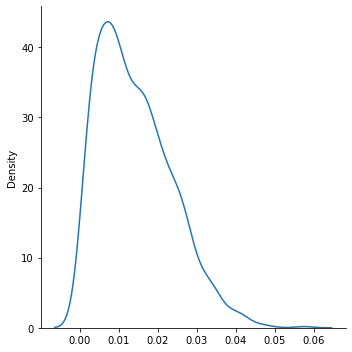

In [91]:
sns.displot(edp_randn, kind='kde')

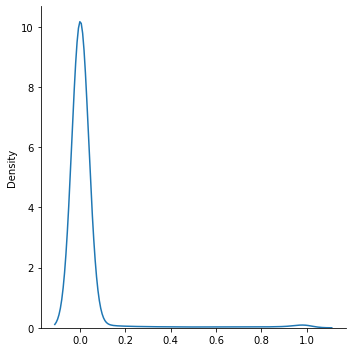

In [100]:
sns.displot(prob_exceedance, kind='kde')

In [102]:
max(IM/g)

2.780807180861065

In [104]:
def fit_IM_against_M_and_Rjb(IM, M, Rjb):
    '''
    return Model fit result
    '''
    temp = {'I': np.ones(shape = len(IM)),
        'lnSaT1': np.log(IM),
        'M': np.log(M),
        'Rjb': np.log(Rjb)}
    dummydf = pd.DataFrame(temp, index = None)
    model = smf.ols('lnSaT1 ~ M + Rjb', data = dummydf)
    model_res = model.fit()
    return model_res
    

In [105]:
im_fit = fit_IM_against_M_and_Rjb(IM, gminfo_rotD50['Magnitude'].values, gminfo_rotD50['Distance_Rjb'].values)

In [106]:
epd_fit_resid_IM = OLS(sdrX, np.exp(im_fit.resid))
epd_fit_resid_IM.result.params
epd_fit_resid_IM.get_pred_values()

const   -5.791181
0        0.359138
dtype: float64

In [112]:
edp_fit_resid_IM = OLS(sdrX, np.exp(im_fit.get_prediction().predicted_mean))
param = edp_fit_resid_IM.result.params

In [113]:
np.median(IM)

148.82980630166082

In [118]:
IM_range = np.linspace(min(IM), max(IM), 1000)


In [ ]:
from scipy.stats import chi2_contingency

def calc_MI(x, y, bins):
    '''
    Calculates mutual information
    '''
    c_xy = np.histogram2d(x, y, bins)[0]
    g, p, dof, expected = chi2_contingency(c_xy, lambda_="log-likelihood", correction=False)
    mi = 0.5 * g / c_xy.sum()
    return mi

In [ ]:
calc_MI(gminfo_rotD50['Magnitude'].values, ols_pfaX.result.resid, bins = 8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, ols_pfaX.result.resid, bins=8)

In [ ]:
calc_MI(gminfo_rotD50['Distance_Rjb'].values, gminfo_rotD50['Magnitude'].values, bins=15)

In [ ]:
calc_MI(IM, gminfo_rotD50['Magnitude'].values, bins=8)

In [ ]:
calc_MI(IM, gminfo_rotD50['Distance_Rjb'].values, bins=8)

In [ ]:
calc_MI(IM, sdrZ_avg, bins=6)

In [ ]:
calc_MI(np.log(sdrZ_avg), np.log(sdrZ_avg), bins=14)

In [ ]:
calc_MI(IM, IM, bins=8)

In [ ]:
pfa.shape

In [ ]:
sdrgmean = gmean([sdrX, sdrZ])
sdr.shape

In [ ]:
np.exp(np.mean([np.log(sdrX[0]), np.log(sdrZ[0])]))

In [ ]:
np.sqrt(sdrX[0]**2 + sdrZ[0]**2)

In [ ]:
angles = np.arange(0, 180, step=1)
radians = np.radians(angles)
coeffs = np.c_[np.cos(radians), np.sin(radians)]
sdr_stacked = np.vstack([sdrX, sdrZ])
rotated_sdr = np.dot(coeffs, sdr_stacked)

In [ ]:
percentile_sdr = np.percentile(rotated_sdr, 50, axis = 0, interpolation='linear')
percentile_sdr.shape

In [ ]:
np.median(rotated_sdr)

In [ ]:
testEff = OLS(sdrX, IM)
np.std(testEff.result.resid)

In [ ]:
testEff = OLS(sdr, IM)
np.std(testEff.result.resid)


In [ ]:
# testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Distance_Rjb'])))
testSuff = sm.OLS(testEff.result.resid, sm.add_constant(np.log(gminfo_rotD50['Magnitude'])))

testSuff.fit().summary()


In [ ]:
testSuff.fit().pvalues


In [ ]:
epsilon_onlyIM = ols_sdrX.result.resid

In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
epsilon_onlyIM_M = model_res.resid

In [ ]:
temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M + lnRjb', data = dummydf)
model_res = model.fit()

In [ ]:
temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
epsilon_onlyIM_R = model_res.resid

In [ ]:
epsilon_IM_and_M_andR = model_res.resid


## KL Divergence

using ```scipy.stats.entropy``` because

If qk is not None, then compute the Kullback-Leibler divergence S = sum(pk * log(pk / qk), axis=axis).

This routine will normalize pk and qk if they don’t sum to 1.

In [ ]:
print(np.std(epsilon_onlyIM), np.std(epsilon_onlyIM_M))

In [ ]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_onlyIM_M)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_onlyIM_R)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
sigma2 = np.std(epsilon_onlyIM)
sigma1 = np.std(epsilon_onlyIM_R)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_IM_and_M_andR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
sigma1 = np.std(epsilon_onlyIM_M)
sigma2 = np.std(epsilon_IM_and_M_andR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
gminfo_rotD50.head()

In [ ]:
gminfo_rotD50['lnRjb'] = np.log(gminfo_rotD50.Distance_Rjb.values)
gminfo_rotD50['lnM'] = np.log(gminfo_rotD50.Magnitude.values)

In [ ]:
import seaborn as sns
sns.displot(data=gminfo_rotD50, x='Magnitude', kde=True)

In [ ]:
sns.displot(data=gminfo_rotD50, x='lnRjb', kde=True)

In [ ]:
sns.scatterplot(data=gminfo_rotD50, x='lnM', y = 'lnRjb')

In [ ]:
sdrX_nocollapse = sdrX[sdrX < 0.1]

In [ ]:
sdrX_nocollapse.shape

In [ ]:
sns.displot(np.log(sdrX_nocollapse))

In [ ]:
from scipy.stats import entropy 

kld = entropy(pk=epsilon_onlyIM, qk=epsilon_IM_and_M)
kld

In [ ]:
from scipy.special import rel_entr
sum(rel_entr(epsilon_onlyIM, epsilon_IM_and_M))

In [ ]:
calc_MI(epsilon_onlyIM, epsilon_IM_and_M, bins=8)

In [ ]:
##### Using residual from efficiency to compute sufficiency instead of direct linear model

temp = {'I': np.ones(shape = int(numGM)),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(IM),
        'M': gminfo_rotD50['Magnitude'].values,
        'lnRjb': np.log(gminfo_rotD50['Distance_Rjb'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
gminfo_rotD50.head()

In [ ]:
gminfo_rotD50['sa(g)'] = np.round(gminfo_rotD50['T_0.13'].values / g, 2)
dict(gminfo_rotD50['sa(g)'].value_counts())

In [ ]:
epsilon_IM_and_M_and_lnR = model_res.resid

In [ ]:
sigma1 = np.std(epsilon_onlyIM)
sigma2 = np.std(epsilon_IM_and_M_and_lnR)
kld_manual = np.log(sigma2 / sigma1) + sigma1 ** 2 / (2 * sigma2 ** 2) - 0.5
kld_manual

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'M': gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
# I = np.ones(shape = numGM)
# Y = np.log()
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values)}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sa_T013 = spectral_acc[T[4]].values
temp = {'I': np.ones(shape = numGM),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues

In [ ]:
sdrXx = sdr[3].values[:numGM][1::2]
len(sdrXx)

In [ ]:
linear_fit = sm.OLS(np.log(sdrX), X)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
linear_fit = sm.OLS(np.log(sdrXx), Xx)
fit_result = linear_fit.fit()
fit_result.summary()

In [ ]:
np.std(fit_result.resid)

In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + M', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
model_res.pvalues['lnRjb']

a = 'Yes' if model_res.pvalues['lnRjb'] >= 0.05 else 'No'

In [ ]:
np.round(model_res.pvalues['lnRjb'], 2)



In [ ]:
temp = {'I': np.ones(shape = 240),
        'lnEDP': np.log(sdrX),
        'lnSaT1': np.log(sa_T013),
        'lnRjb': np.log(gm_info['Distance 1 (km)'].values),
        'M':gm_info['Magnitude'].values}
dummydf = pd.DataFrame(temp, index = None)
model = smf.ols('lnEDP ~ lnSaT1 + lnRjb', data = dummydf)
model_res = model.fit()
model_res.summary()

In [ ]:
sns.histplot(fit_result.resid)

In [ ]:
mu, std = norm.fit(fit_result.resid)
mu, std

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
np.std(fit_result.resid)

In [ ]:
ols_sdrX_saT1 = OLS(sdrX, sa_T013)

In [ ]:
ols_sdrX_saT1.get_summary()

In [ ]:
ols_sdrX_saT1.plot_model_fit()

In [ ]:
ols_sdrX_saT1.plot_residuals_hist()

In [ ]:
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')

plt.show()

In [ ]:
x


In [ ]:
y

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [30, 20, 10, 0]):
    xs = np.arange(20)
    ys = np.random.rand(20)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    cs[0] = 'c'
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
z